In [331]:
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import yen
import pandas as pd

#### *Load Network Topology*

In [93]:
# Load the .mat file
mat_data = scipy.io.loadmat(r'E:\University\Master\Project\Codes\6D-MAN\MAN157Nodes.mat')

# Display the keys in the loaded dictionary
print(mat_data.keys())

net_topology = mat_data['MAN157Nodes']
net_topology_ex = net_topology.copy()

print('the type of net_topology:', type(net_topology_ex))

topo_size = net_topology_ex.shape
print('the shape of net_topology: ', topo_size)

dict_keys(['__header__', '__version__', '__globals__', 'MAN157Nodes'])
the type of net_topology: <class 'numpy.ndarray'>
the shape of net_topology:  (157, 157)


In [94]:
# Make the adjacenccy matrix upper triangular
net_topology_ex = np.triu(net_topology_ex)

In [95]:
# Create graph from adjacency matrix
net_graph = nx.from_numpy_array(net_topology_ex)

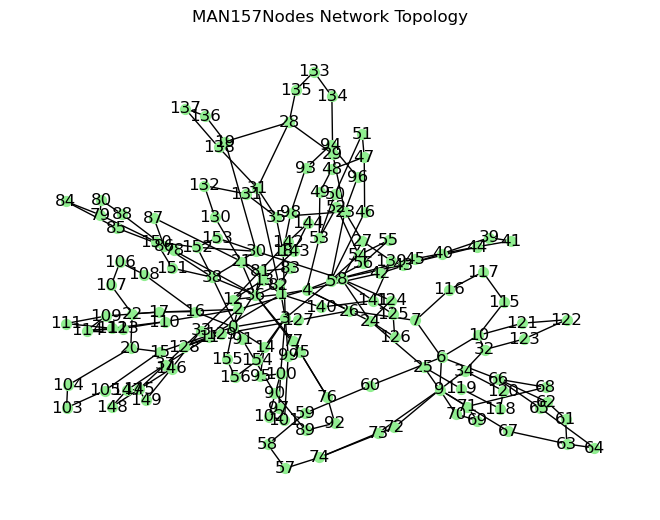

In [96]:
# Draw the graph
nx.draw(net_graph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.title('MAN157Nodes Network Topology')
plt.show()

#### *Extract all source-destination-weight pairs*

In [97]:
src_des_weight = list(net_graph.edges(data = 'weight'))
src_des_weight_matrix = np.array(src_des_weight)

print('the shape of source-destination-weight matrix:', src_des_weight_matrix.shape)

the shape of source-destination-weight matrix: (220, 3)


##### *Some statistical analysis of links*

In [98]:
num_links = src_des_weight_matrix.shape[0]

print('number of links:', num_links)
print('maximum link weight:', src_des_weight_matrix[:, 2].max())
print('maximum link weight:', src_des_weight_matrix[:, 2].min())
print('average link weight:', src_des_weight_matrix[:, 2].mean())

number of links: 220
maximum link weight: 65.67
maximum link weight: 0.7
average link weight: 11.137363636363638


##### *Calculate the number of optical amplifier spans required for signal transmission*

In [99]:
# Define span length of 70 km
span_length = 70

# Calculate the number of spans required for each link
num_spans_per_link = np.ceil(src_des_weight_matrix[:, 2] / span_length)

#### *Node categorization into hierarchical levels*

In [100]:
# manually assign nodes 2 and 6 into HL1 level
HL1_StandAlone = np.array([1, 5])

# manually assign nodes [0 2 3 4] into HL1 level
HL2_StandAlone = np.array([0, 2, 3, 4])

# manually assign nodes 6 to 38 into HL1 level
HL3_StandAlone = np.arange(6, 39)

# manually assign nodes 39:topo_size(1) into HL1 level
HL4_StandAlone = np.arange(39, topo_size[1])

# concatenated HL1, HL2, HL3 nodes
HL123_standalone = np.concatenate((HL1_StandAlone, HL2_StandAlone, HL3_StandAlone))

# there is a colocated HL4 router in each upper level routers (HL1, HL2, HL3)
HL4_colocated = np.sort(HL123_standalone)

# concatenate all HL4 nodes consist of standalone and colocated
HL4_all = np.concatenate((HL4_colocated, HL4_StandAlone))

# there is colocated HL3 routers in HL1 and HL2 nodes
HL3_colocated = np.concatenate((HL1_StandAlone, HL2_StandAlone))

# there is colocated HL2 routers in HL1 nodes
HL2_colocated = HL1_StandAlone

##### *Calculate node degree of each hierarchical level nodes*


In [101]:
# calculate HLx subnet graphs
HL4_subgraph = net_graph.subgraph(HL4_StandAlone).copy() # HL4 subnet graph
HL3_subgraph = net_graph.subgraph(HL3_StandAlone).copy() # HL3 subnet graph
HL2_subgraph = net_graph.subgraph(HL2_StandAlone).copy() # HL2 subnet graph
HL1_subgraph = net_graph.subgraph(HL1_StandAlone).copy() # HL1 subnet graph

# calculate node degree of different HLx
HL4_degrees = np.array(net_graph.degree(HL4_StandAlone))
HL3_degrees = np.array(net_graph.degree(HL3_StandAlone))
HL2_degrees = np.array(net_graph.degree(HL2_StandAlone))
HL1_degrees = np.array(net_graph.degree(HL1_StandAlone))

##### *Some statistical analysis of node degrees*

In [102]:
print('maximum node degree of HL4 routers:', HL4_degrees.max(axis = 0)[1])
print('minimum node degree of HL4 routers:', HL4_degrees.min(axis = 0)[1])
print('average node degree of HL4 routers:', HL4_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL3 routers:', HL3_degrees.max(axis = 0)[1])
print('minimum node degree of HL3 routers:', HL3_degrees.min(axis = 0)[1])
print('average node degree of HL3 routers:', HL3_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL2 routers:', HL2_degrees.max(axis = 0)[1])
print('minimum node degree of HL2 routers:', HL2_degrees.min(axis = 0)[1])
print('average node degree of HL2 routers:', HL2_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL1 routers:', HL1_degrees.max(axis = 0)[1])
print('minimum node degree of HL1 routers:', HL1_degrees.min(axis = 0)[1])
print('average node degree of HL1 routers:', HL1_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')


maximum node degree of HL4 routers: 5
minimum node degree of HL4 routers: 2
average node degree of HL4 routers: 2.2711864406779663
-----------------------------------------------------------------
maximum node degree of HL3 routers: 8
minimum node degree of HL3 routers: 3
average node degree of HL3 routers: 3.9393939393939394
-----------------------------------------------------------------
maximum node degree of HL2 routers: 8
minimum node degree of HL2 routers: 5
average node degree of HL2 routers: 6.75
-----------------------------------------------------------------
maximum node degree of HL1 routers: 8
minimum node degree of HL1 routers: 7
average node degree of HL1 routers: 7.5
-----------------------------------------------------------------


#### *Plot HL4 subnet graph*

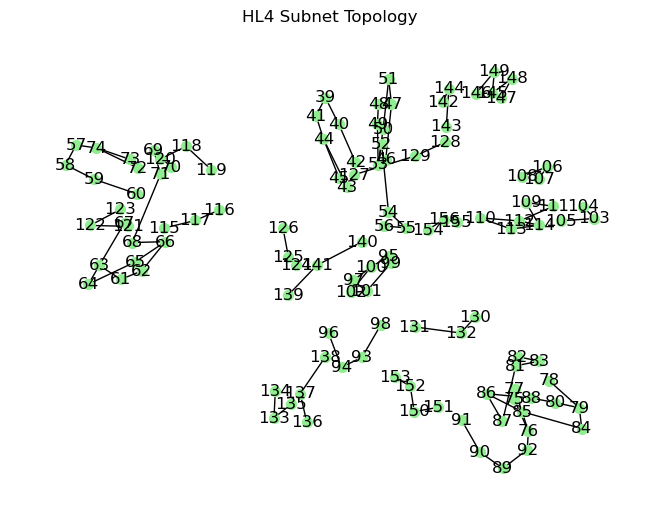

In [103]:
nx.draw(HL4_subgraph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.title('HL4 Subnet Topology')
plt.show()

#### *Define Cost Matrices*

In [104]:
# Define cost matrix of whole network
netCostMatrix = nx.to_numpy_array(net_graph, weight='weight', nonedge = np.inf)

# Define cost matrix of HL4 subnet
netCostMatrix_HL4 = nx.to_numpy_array(HL4_subgraph, weight='weight', nonedge = np.inf)

#### *Define some parameters*

In [105]:
# define target BER
target_ber = 1e-2

# multi-format loss factors - commented suggest no loss cosideration
phi_MFL =  -1 * [1, 1, 2/3, 17/25, 69/100, 13/21]
# phi_MFL = zeros(1, 6);

epsilon = 0

# define third-order dispersion coefficient
beta_3 = 0.14e-39
Cr = 0.028 / 1e3 / 1e12

# define attenuation coeff (dB/km)
alpha_db = 0.2

# normalized attenuation coeff
alpha_norm = alpha_db / (10 * np.log10(np.exp(1)) * 1e3)

# group velocity dispersion (s^2/m)
beta_2 = -21.7e-27

# define nonlinear parameter (1/(W.m)
gama = 1.21e-3

L_eff_a = 1 / alpha_norm

# noise figure 6 dB
F_C = np.power(10, 0.45)    
F_L = np.power(10, 0.5)         

# Planck's constant (J s)
h_plank = 6.626e-34   

# L_eff is defined as (1 - e ^ (alpha * L_s)) / alpha
L_eff=(1 - np.exp(-1 * alpha_norm * span_length)) / (alpha_norm)


#### *Calculate all HL1, HL2, HL3 nodes that have any connection to HL4s*

In [106]:
# define set to avoid duplicates
HL4_connected_nodes = set() 
for node in HL4_StandAlone:
    HL4_connected_nodes.update(net_graph.neighbors(node))

# Remove the target nodes themselves from the result
HL4_connected_nodes -= set(HL4_StandAlone)

print("Connected higher hierarchical nodes to HL4s:\n", HL4_connected_nodes)

Connected higher hierarchical nodes to HL4s:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}


#### *K pair link- and node-disjoint shortest paths for HL4 nodes by using DLN_Algorithm*

> ##### Note: *for standalone HL4s we have the primary and secondary, but for colocated HL4 we have only secondary paths. (primary is in it's node)*
> ##### *K_path_attributes's columns --> | 1: source node | 2: destination node | 3: nodes list | 4: distance | 5: links list | 6: number of hops*

##### *Standalone HL4s*

*Define a function to extract all nodes in a certain path*

In [279]:
def nodes_in_path(predecessors, path_index, source, target):
    """Reconstructs the i-th shortest path from the predecessors matrix."""
    path = []
    node = target
    while node != -9999 and node != source:
        path.append(node)
        node = predecessors[path_index, node]
    if node != -9999:
        path.append(source)
        return path[::-1]  # Reverse path to get source-to-target order
    return []  # No path found

*Define a function to extract all links in a certain path*

In [280]:
def links_in_path(all_links, path):
    links_array = []
    for i in range(len(path)):
        if i != len(path) - 1:
            link_idx = np.where(((all_links[:, 0] == path[i]) & (all_links[:, 1] == path[i + 1])) | ((all_links[:, 0] == path[i + 1]) & (all_links[:, 1] == path[i])))[0]
            links_array.append(link_idx[0])

    return links_array

*Calculate K_shortest path between standalone HL4s and possible destinations*

In [ ]:
# # create scipy graph to use Yen algorithm
# graph = csr_matrix(netCostMatrix)

# # all links in the whole network array
# all_links = np.array(list(net_graph.edges(data = 'weight')))

# # define how many paths will calc between each source-destination pair
# k_paths = 20

# # define a list to store path attributes
# K_path_attributes = []

# # iterate through each standalone HL4 node
# for src in HL4_StandAlone:

#     for dest in HL4_connected_nodes:
#         local_dict = {}
#         # print(src, dest)
#         # K_path_attributes.append(local_dict)
#         dist_array, predecessors = yen(csgraph = graph, source = src, sink = dest, K = k_paths, directed = False, return_predecessors = True)

#         # Reconstruct and display all paths
#         for candidate_path, dist in enumerate(dist_array):
#             path = nodes_in_path(predecessors, candidate_path, src, dest)
#             links_array = links_in_path(all_links, path)

#             local_dict = {}
#             local_dict['src_node'] = src
#             local_dict['dest_node'] = dest
#             local_dict['nodesList'] = path
#             local_dict['distance'] = dist
#             local_dict['linksList'] = links_array
#             local_dict['numHops'] = len(path) - 1

#             K_path_attributes.append(local_dict)

# # Convert K_path_attributes list to dataframe
# df = pd.DataFrame(K_path_attributes)

# # save dataframe to csv file
# df.to_csv(r'.\K_path_attributes.csv', index = False)


*Note: we calculate the K_shortest_path once, after that just load the csv file*

In [332]:
K_path_attributes_df = pd.read_csv(r'.\K_path_attributes.csv')

In [333]:
K_path_attributes_df.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,0,"[39, 41, 44, 45, 5, 23, 35, 31, 1, 12, 13, 0]",72.31,"[119, 121, 123, 31, 29, 83, 98, 12, 10, 60, 2]",11
1,39,0,"[39, 41, 44, 43, 5, 23, 35, 31, 1, 12, 13, 0]",73.31,"[119, 121, 122, 30, 29, 83, 98, 12, 10, 60, 2]",11
2,39,0,"[39, 41, 44, 45, 5, 23, 29, 28, 31, 1, 12, 13, 0]",80.31,"[119, 121, 123, 31, 29, 82, 91, 92, 12, 10, 60...",12
3,39,0,"[39, 41, 44, 43, 5, 23, 29, 28, 31, 1, 12, 13, 0]",81.31,"[119, 121, 122, 30, 29, 82, 91, 92, 12, 10, 60...",12
4,39,0,"[39, 40, 42, 4, 24, 124, 8, 30, 19, 28, 31, 1,...",82.12,"[118, 120, 27, 25, 86, 45, 44, 74, 73, 92, 12,...",14
